# Abstract


Designed so so that run like script
Run all boxes
Copy onto .py file sequentially, will still work (except load from google drive part)

in particular, script part should only consist of simple functions
as long as all the definition parts are there, script code snippet, order does not matter

Style: functions should be self contained
Pass all the info it needs to do the computation through the arguments
Avoid using global var


# Preparations

## Access Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive'
save_path = '/content/drive/My Drive/QITI/Saved_Files/'

# %matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports and Definitions

In [12]:
import time
from datetime import datetime, timezone
from prettytable import PrettyTable
import pytz

import os
import sys

path = os.path.abspath(drive_path+"/QITI/Packages/TrICal/")  # Path to TrICal package
sys.path.append(path)  # Add path to TrICal package

import scipy as sp

# Numpy
import numpy as np
from numpy.polynomial import polynomial as poly

np.set_printoptions(formatter={"all": lambda x: "{:.3g}".format(x)})

# Matplotlib
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib import rc
from matplotlib.widgets import Button, Slider
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Uncomment these
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = False # True

# TrICal
import trical
from trical.misc import constants as cst

def flatten_index(x_idx,y_idx,z_idx):
    return 21*x_idx+7*y_idx+z_idx

def init_idx_list():
    _list = []
    for I in range(3):
        for J in range(3):
            for K in range(5):
                _list.append((I,J,K))

    # # 0th order
    # _list.append((0,0,0)) # 1
    #
    # # 1st order
    # _list.append((1,0,0)) # x
    # _list.append((0,1,0)) # y
    # _list.append((0,0,1)) # z
    #
    # # 2nd order
    # _list.append((2,0,0)) # x^2
    # _list.append((0,2,0)) # y^2
    # _list.append((0,0,2)) # z^2
    # _list.append((1,1,0)) # xy
    # _list.append((1,0,1)) # xz
    # _list.append((0,1,1)) # yz
    #
    # # 3rd order
    # _list.append((2,1,0)) # x^2y
    # _list.append((2,0,1)) # x^2z
    # _list.append((1,2,0)) # xy^2
    # _list.append((0,2,1)) # y^2z
    # _list.append((1,0,2)) # xz^2
    # _list.append((0,1,2)) # yz^2
    # _list.append((1,1,1)) # xyz
    # _list.append((0,0,3)) # z^3
    #
    # # 4th order
    # _list.append((0,0,4)) # z^4
    # _list.append((2,0,2)) # x^2z^2
    # _list.append((0,2,2))  # y^2z^2

    return _list

def coeff_calc(omega,dim_idx):
    return 0.5*m*(omega[dim_idx]**2)

def b_rot_init(omega):
    # b_tmp = np.zeros(len(idx_list))
    b_tmp = np.zeros((3,3,5))
    coeff_x = coeff_calc(omega,0) # orignal x^2 coeff
    coeff_y = coeff_calc(omega,1) # orignal y^2 coeff

    b_tmp[2,0,0] = (coeff_x+coeff_y)/2
    b_tmp[1,1,0] = -coeff_x+coeff_y
    b_tmp[0,2,0] = (coeff_x+coeff_y)/2
    b_tmp[0,0,2] = coeff_calc(omega,2)
    return b_tmp.flatten()

def b_gen_rot_init(omega,theta):
    b_tmp = np.zeros((3,3,5))
    coeff_x = coeff_calc(omega,0)  # orignal x^2 coeff
    coeff_y = coeff_calc(omega,1)  # orignal y^2 coeff

    b_tmp[2,0,0] = coeff_x*(np.cos(theta)**2)+coeff_y*(np.sin(theta)**2)
    b_tmp[1,1,0] = 2*np.cos(theta)*np.sin(theta)*(-coeff_x+coeff_y)
    b_tmp[0,2,0] = coeff_x*(np.sin(theta)**2)+coeff_y*(np.cos(theta)**2)
    b_tmp[0,0,2] = coeff_calc(omega,2)
    return b_tmp.flatten()


def bounds_init():
    # NOT 335, should be 21!!!!
    lb_tmp = np.full((4,5), -np.inf)
    ub_tmp = np.full((4, 5), np.inf)
    for _I_ in range(4):
        lb_tmp[_I_,0] = 0
        lb_tmp[_I_,4] = 0
        ub_tmp[_I_,0] = 1000
        ub_tmp[_I_,4] = 1000



    DC_lb = lb_tmp.flatten()
    DC_ub = ub_tmp.flatten()
    return (np.append(DC_lb,-np.inf),np.append(DC_ub,np.inf))

# def to_square_mat(in_mat,in_AC):
#     # in_mat shape (4, 5, 3, 3, 5)
#     # in_AC shape (3, 3, 5)

#     # maps the DC electrodes 1 to 20 to indices in a (4,5) array
#     map = []
#     for _I in range(20):
#         map.append((_I // 5, _I % 5))

#     out_mat = np.zeros((21, 21))
#     # 1st idx = power, 2nd idx = electrode
#     # first 20 indices = DC
#     for _k in range(21):
#         if _k != 20: # DC electrodes
#             A = in_mat[map[_k]] # basis for _kth electrode
#             # shape (3,3,5)
#         else: # AC electrode
#             A = in_AC
#         for _j in range(21):
#             out_mat[_j,_k] = A[idx_list[_j]]
#     return out_mat

# in_mat is the part of the matrix that maps the DC voltages
# append this matrix by the row that maps the AC voltages
def to_rect_mat(in_mat,in_AC,idx_list):
    """
    in_mat shape (4, 5, 3, 3, 5)
    in_AC shape (3, 3, 5)

    returns out_mat with shape (45, 21)
    column (21) = DC electrodes (0,0), (0,1), ..., (0,4), (1,0) then AC
    row (45) = polynomial power coefficients ordered as in idx_list
    currently (I,J,K): (0,0,0), (0,0,1), ..., (0,1,0), ... (ie flatten)
    """

    # maps the DC electrodes 1 to 20 to indices in a (4,5) array
    # (0,0), (0,1), ..., (0,4), (1,0), ...
    map = []
    for _I in range(20):
        map.append((_I // 5, _I % 5))

    out_mat = np.zeros((45, 21))
    # 1st idx = power, 2nd idx = electrode
    # first 20 indices = DC
    for _k in range(21): # _kth electrode
        if _k != 20: # DC electrodes
            A = in_mat[map[_k]] # basis for _kth electrode
            # shape (3,3,5)
        else: # AC electrode
            A = in_AC
        for _j in range(len(idx_list)):
            out_mat[_j,_k] = A[idx_list[_j]]
    return out_mat

# Removes dimensions from polynomial coefficient for b
def non_dim_b(dim_b, idx_list, l=1e-6):
    pow = np.array([sum(tup) for tup in idx_list])
    return (
        dim_b
        * (l / (cst.k * cst.e ** 2))
        * (l ** pow)
    )

# def add_weights_to_mat(unweighted_mat):

def pow_to_grid_mat_init(XX,YY,ZZ):
    '''
    In the grid level optimization, this maps the voltages to the potential on 
    the grid
    Note that the grid can be of any shape 
    (does not have to be the same as that from COMSOL)
    It doesn't have to be equispaced?
    '''
    X_pows = [XX**0,XX**1,XX**2]
    Y_pows = [YY**0,YY**1,YY**2]
    Z_pows = [ZZ**0,ZZ**1,ZZ**2,ZZ**3,ZZ**4]

    # num of row (dim 1) = 45; number of col (dim 2) = eg 44541 (number of grid points)
    mat_tmp = np.zeros((0,np.size(XX)))
    print(mat_tmp)
    print(np.shape(mat_tmp))
    for I in range(3):
        for J in range(3):
            for K in range(5):
                tmp = X_pows[I]*Y_pows[J]*Z_pows[K]
                tmp = np.array([tmp.flatten()])
                mat_tmp = np.append(mat_tmp, tmp, axis=0)
    # (44541, 45)
    mat_tmp = np.transpose(mat_tmp)
    return mat_tmp


# FUNCTIONS COPIED FROM NOTEBOOK

# Removes dimensions from polynomial coefficient for the potential
def nondimensionalize(alpha, l=1e-6, batchdim=0):
    return (
            alpha
            * (l / (cst.k * cst.e ** 2))
            * l ** np.indices(alpha.shape[batchdim:]).sum(0)
    )


# Reintroduces dimensions into polynomial coefficient for the potential
def redimensionalize(nd_alpha, l, batchdim=0): # l=1e-6
    return (
            nd_alpha
            * (cst.k * cst.e ** 2 / l)
            / l ** np.indices(nd_alpha.shape[batchdim:]).sum(0)
    )

# Multiplies 3D multivariate polynomials
def polymul3d(alpha1, alpha2):
    alpha = np.zeros(np.array(alpha1.shape) + np.array(alpha2.shape) - 1)
    for i, j, k in np.indices(alpha2.shape).reshape(3, -1).transpose():
        alpha += (
            np.pad(
                alpha1,
                pad_width=[
                    [i, alpha2.shape[0] - i - 1],
                    [j, alpha2.shape[1] - j - 1],
                    [k, alpha2.shape[2] - k - 1],
                ],
            )
            * alpha2[i, j, k]
        )
    return alpha



def optimize_quartic_z(N, mean_spacing=3, l=1e-6):
  """
  calculates the optimized z potential for N ions and a mean spacing

  N: number of ions
  mean_spacing: mean spacing of ions in length scale units
  l: length scale
  """

  # Gradient of Coulomb potential
  cp = trical.classes.CoulombPotential(N, dim=1)
  x_ep = np.linspace(-(N - 1) / 2, (N - 1) / 2, N) * mean_spacing
  x_ep = x_ep.reshape(-1, 1)
  ndGcp = cp.nondimensionalize(l=l).gradient()(x_ep)

  # Finds z-polynomial that minimizes gradient of potential
  degz = 4  # Degree of polynomial to use for z-potential
  A = x_ep ** np.arange(degz) * np.arange(1, degz + 1)
  res = np.linalg.lstsq(A, -ndGcp, rcond=None)

  alpha_z = np.zeros(degz + 1)
  alpha_z[1:] = res[0]

  alpha = redimensionalize(alpha_z, l=l, batchdim=0)

  # Define trapped-ion system for the above solution
  tp = trical.classes.PolynomialPotential(alpha, N=N)
  ndGtp = tp.nondimensionalize(l=l).gradient()(x_ep)

  ti = trical.classes.TrappedIons(N, tp, m=m, dim=1, l=l)
  ti.principle_axis()

  # Separation between ions
  dz = (np.sort(ti.x_ep, 0)[1:] - np.sort(ti.x_ep, 0)[:-1]).flatten()[: N // 2]

  print(
      "{:<20} {:<25} {:<40}".format(
          "Excluded Ions", "Rel. Separation Std. (%)", "Max Rel. Diff. Separation (%)"
      )
  )
  for i in range(N // 2):
      print(
          "{:<20} {:<25.3g} {:<40.3g}".format(
              i,
              dz[i:].std() / dz[i:].mean() * 100,
              (np.abs(dz[i:] - dz[i:].mean())).max() / dz[i:].mean() * 100,
          )
      )

  print(alpha_z)
  return alpha_z, ti


### nbk_init function

In [13]:
# based on code in test.ipynb code
# returns nd_alpha_DC, nd_alpha_AC, grid XX, YY, ZZ
def nbk_init(simtype):
  r0 = 0.2
  blade_angle = 60
  # simtype = "finer" # finer
  filename = drive_path + "/QITI/Packages/Blade Trap Simulation/" \
              "blade_assembly_for_electrode_simulation_r0={r0:.1f}_blade_angle={angle:2d} ({simtype})/electrode_{domain}.npy"

  # Create grid of coords
  basis_range = dict(
      coarse=np.array([[-2e-4, 2e-4, 5e-6], [-2e-4, 2e-4, 5e-6], [-5e-4, 5e-4, 5e-6]]),
      fine=np.array([[-4e-5, 4e-5, 1e-6], [-4e-5, 4e-5, 1e-6], [-5e-4, 5e-4, 5e-6]]),
      finer=np.array([[-4e-6, 4e-6, 1e-7], [-4e-6, 4e-6, 1e-7], [-5e-5, 5e-5, 1e-6]]),
  )[simtype]
  grid_size = np.array(
      [int((stop - start) / step) + 1 for (start, stop, step) in basis_range]
  )
  RR = np.array(
      np.meshgrid(*[np.linspace(*basis_range[i, :-1], grid_size[i]) for i in range(3)])
  ).swapaxes(1, 2)
  XX, YY, ZZ = RR

  # Load grid of values of simulated blade potentials
  VV = np.array(
      [
          np.load(
              filename.format(r0=r0, angle=blade_angle, domain=i + 1, simtype=simtype)
          )[:, -1]
          for i in range(3)
      ]
  )
  VV = np.rollaxis(VV.reshape(3, *grid_size[-1::-1]), 0, 4).transpose()

  # print(RR)
  # sys.exit()

  # print(VV)
  # print(np.shape(VV))
  # sys.exit()

  # DC
  deg = np.array([2, 2, 4])  # Degree of polynomial to fit simulated blade potentials

  # Fitting polynomial to the simulated blade potentials
  alpha_DC = [
      trical.misc.polynomial.multivariate_polyfit(
          RR.reshape(3, -1).transpose(), VV[i].flatten(), deg, l
      )
      for i in range(3)
  ]

  # Simulated blade potentials grid based on the polynomial fit
  VV2 = np.array([poly.polyval3d(*RR, i) for i in alpha_DC])

  # Use z-reflection of polynomial to add segments symmetrically
  idcs = np.indices(deg + 1)
  for i in range(1, -1, -1):
      alpha_DC.append(alpha_DC[i] * (-1) ** idcs[-1])

  # Symmetrize center blade segment
  alpha_DC[2] = (alpha_DC[2] + alpha_DC[2] * (-1) ** idcs[-1]) / 2

  # Use xy-reflections of polynomial to add blades symmetrically
  alpha_DC = np.array(alpha_DC)
  alpha_DC = np.concatenate((alpha_DC, alpha_DC * (-1) ** idcs[0]))
  alpha_DC = np.concatenate((alpha_DC, alpha_DC * (-1) ** idcs[1]))
  alpha_DC = alpha_DC.reshape(4, 5, *(deg + 1)) * cst.e

  # Nondimensionalized polynomial coefficients for the potential
  nd_alpha_DC = nondimensionalize(alpha_DC, l=l, batchdim=2)

  # AC
  # Gradient of blade potentials
  grad_alpha_DC = [
      poly.polyder(
          (alpha_DC.sum(1) * np.array([1, -1, -1, 1]).reshape(-1, 1, 1, 1)).sum(0),
          axis=j,
      )
      for j in range(-3, 0)
  ]

  # Polynomial coefficients for AC potential
  alpha_AC = [polymul3d(i, i) for i in grad_alpha_DC]
  deg_AC = np.array([i.shape for i in alpha_AC]).max(0)
  alpha_AC = np.sum(
      [
          np.pad(
              i,
              pad_width=[
                  [0, deg_AC[0] - i.shape[0]],
                  [0, deg_AC[1] - i.shape[1]],
                  [0, deg_AC[2] - i.shape[2]],
              ],
          )
          for i in alpha_AC
      ],
      0,
  )

  Omega_AC = 2 * np.pi * 3.5e7
  V_AC_factor = 1 / (4 * m * Omega_AC ** 2)

  alpha_AC *= V_AC_factor

  # Nondimensionalized polynomial coefficients for AC potential
  nd_alpha_AC = nondimensionalize(alpha_AC, l=l, batchdim=0)

  return nd_alpha_DC, nd_alpha_AC, XX, YY, ZZ

### VoltageOptim Class

In [14]:
class VoltageOptim:
  '''
  Optimzes the voltages in 4 different ways: v
  Computes the corresponding polynomial coefficients: checking

  Options at initialization:
    simtype = coarse, fine, finer
    init_type = quadratic, quartic
    optim_type = coeff, grid
  '''
  def __init__(self,simtype,ion_number,init_type,optim_type):
    self.simtype = simtype
    self.ion_number = ion_number
    self.init_type = init_type
    self.optim_type = optim_type

    print(f"optimization type: {self.optim_type}")
    print(f"ion number = {self.ion_number}")
    if self.optim_type == 'coeff':
      self.weights = True
      self.grid_optim = False
    elif self.optim_type == 'grid':
      self.weights = False
      self.grid_optim = True
    else:
      print(f"Error: optim_type = {self.optim_type}")
      sys.exit()

    # weights = np.array([[[1e12, 1e14, 1e4, 1e17, 1e07],
    #                      [1e14, 1e14, 1e16, 1e17, 1e21],
    #                      [1e1, 1e16, 1e05, 1e20, 1e09]],
    #                     [[1e14, 1e15, 1e16, 1e17, 1e21],
    #                      [1e15, 1e16, 1e17, 1e14, 1e14]
    #                      [1e16, 1e16, 1e20, 1e19, 1e23]],
    #                     [[1e1, 1e17, 1e05, 1e21, 1e09],
    #                      [-5.26e-17, -1.22e-16, 7.87e-20, 2.47e-20, -2.72e-23],
    #                      [-6.25e-06, 7.77e-19, -1.03e-08, -2.29e-22, 3.63e-12]]]).flatten()

    self.nd_alpha_DC, self.nd_alpha_AC, self.XX, self.YY, self.ZZ = nbk_init(self.simtype)

    self.nd_alpha_AC = self.nd_alpha_AC[0:3,0:3,0:5] # resize array, remove higher powers

    print(f"notebook shape = {np.shape(self.nd_alpha_DC)}")

    self.idx_list = init_idx_list()

    if self.optim_type == 'grid':
      # grid shape(81, 81, 101), l = 1e-6
      # X: -4, -3.9, -3.8, ..., 3.9, 4 microns (81)
      # Y: -4, -3.9, -3.8, ..., 3.9, 4 microns (81)
      # Z: -50,-49,-48,..,49,50 microns (101)
      # position needs to be nondimensionalized

      # even
      # basis_range = np.array([[-4, 4, 1], [-4, 4, 1], [-60, 60, 1]])
      # best so far?

      # basis_range = np.array([[-10, 10, 1], [-10, 10, 1], [-60, 60, 1]])
      # accurate x^2, y^2; no COM mode? all decoupled; bad eqm positiosn 
      # (squished, two oscillators)

      basis_range = np.array([[-4, 4, 1], [-4, 4, 1], [-110, 110, 1]])
      self.XX, self.YY, self.ZZ = self.grid_init(basis_range=basis_range)
      # noneven
      # self.XX, self.YY, self.ZZ = self.grid_noneven_init()

      self.pow_to_grid_mat = pow_to_grid_mat_init(self.XX,self.YY,self.ZZ)
      
      # deprecated
      # self.XX = self.XX/l
      # self.YY = self.YY/l
      # self.ZZ = self.ZZ/l

      # XX = XX[30:51,30:51,:]/l
      # YY = YY[30:51,30:51,:]/l
      # ZZ = ZZ[30:51,30:51,:]/l

      # XX = XX[30:61,30:61,:]/l
      # YY = YY[30:61,30:61,:]/l
      # ZZ = ZZ[30:61,30:61,:]/l

      # 4000 and biased x,y fit
      # XX = XX[30:61,30:61,:]/l
      # YY = YY[30:61,30:61,:]/l
      # ZZ = ZZ[30:61,30:61,:]/l

      # perfect fit if 1200
      # XX = XX[30:51,30:51,:]/l
      # YY = YY[30:51,30:51,:]/l
      # ZZ = ZZ[30:51,30:51,:]/l

      # all > 4 microns, x,y=0, somewhat quadratic but inner ions equidistant; 351 V
      # XX = XX[30:51,30:51,30:71]/l
      # YY = YY[30:51,30:51,30:71]/l
      # ZZ = ZZ[30:51,30:51,30:71]/l

      # XX = XX[30:51,30:51,20:81]/l
      # YY = YY[30:51,30:51,20:81]/l
      # ZZ = ZZ[30:51,30:51,20:81]/l

      # x, y =0; decent z
      # XX = XX/l
      # YY = YY/l
      # ZZ = ZZ/l

      # quadratic fit
      # XX = XX[:,:,20:81]/l
      # YY = YY[:,:,20:81]/l
      # ZZ = ZZ[:,:,20:81]/l

      # XX = XX[:,:,10:91]/l
      # YY = YY[:,:,10:91]/l
      # ZZ = ZZ[:,:,10:91]/l


    # b = b_init(self.omega) # x, y principal axes
    # b = b_rot_init(self.omega) # rotated principal axes by 45
    # b = b_gen_rot_init(self.omega,(95/90)*np.pi/2) # rotated principal axes

    if self.init_type == 'quadratic':
      self.omega = [5e6*2*np.pi, 4.8e6*2*np.pi, 5e4*2*np.pi]
      self.b = self.b_quadratic_init(self.omega)
    elif self.init_type == 'quartic':
      self.omega = [5e6*2*np.pi, 4.8e6*2*np.pi]
      self.b = self.b_quartic_init(self.omega)
    else:
      print(f"Error: {self.init_type} is not a supported initialization type")
      print(f"Only quadratic and quartic are supported")
      sys.exit()

    print(f"b vector with dimensions = {self.b}")
    print(f"shape = {self.b.shape}\n")
    self.nd_b = non_dim_b(self.b,self.idx_list,l=l)
    self.rect_nbk = to_rect_mat(self.nd_alpha_DC, self.nd_alpha_AC, self.idx_list)

    # perfect fit:
    # 20 ions, spacing = 4: factor4 = 1e6, factor2 = 1e3
    # 20-40 ions, spacing = 3 or 4: factor4 = 5e6, factor2 = 1e3
    # idea: multiply by factor so that coeff ~0.1 (order of magnitude)
    
    # self.weight_factor4 = 5e6 # 1e7 
    # self.weight_factor2 = 1e3 

    if self.optim_type == 'coeff':
      self.passed_weights = np.ones((3,3,5))
      if self.init_type == 'quadratic':
        self.passed_weights[0,0,2] = 1e3
        self.passed_weights[0,0,4] = 5e5
      elif self.init_type == 'quartic':
        # self.passed_weights[0,0,2] = 1e3
        # self.passed_weights[0,0,4] = 5e6

        self.passed_weights[0,0,2] = 1e3
        self.passed_weights[0,0,4] = 5e6
        self.passed_weights[2,0,2] = 1e5
        self.passed_weights[0,2,2] = 1e5

        # self.passed_weights[2,0,4] = 5e8
        # self.passed_weights[0,2,4] = 5e8

      print(f"weights = {self.passed_weights}")
      self.passed_weights = self.passed_weights.flatten()

    # TO DO: remove mention of nbk_grid when not doing grid level optimization
    if self.grid_optim:
        self.rect_nbk_grid = np.matmul(self.pow_to_grid_mat,self.rect_nbk)
        self.nd_b_grid = np.matmul(self.pow_to_grid_mat,self.nd_b)
    else:
        self.rect_nbk = to_rect_mat(self.nd_alpha_DC, self.nd_alpha_AC, self.idx_list)
        self.rect_nbk_grid = self.rect_nbk.copy()  # np.matmul(pow_to_grid_mat,rect_nbk)
        self.nd_b_grid = self.nd_b.copy()  # np.matmul(pow_to_grid_mat,nd_b)

        if self.weights:
            # self.rect_nbk_grid[4] = self.rect_nbk_grid[4]*self.weight_factor4 # z^4 coeff is the 5th term
            # self.nd_b_grid[4] = self.nd_b_grid[4]*self.weight_factor4

            # self.rect_nbk_grid[2] = self.rect_nbk_grid[2] * self.weight_factor2  # z^2 coeff is the 3th term
            # self.nd_b_grid[2] = self.nd_b_grid[2] * self.weight_factor2
            self.nd_b_grid = self.nd_b_grid*self.passed_weights

            # each weight applies to an entire row in rect_nbk_grid
            self.passed_weights = np.broadcast_to(self.passed_weights, (21, 45))
            # new shape (45, 21), same as self.rect_nbk_grid
            self.passed_weights = np.transpose(self.passed_weights) 
            self.rect_nbk_grid = self.rect_nbk_grid*self.passed_weights


    # print(sq_nbk)
    print("notebook")
    print(np.shape(self.rect_nbk))
    # nbk_det = np.linalg.det(rect_nbk)
    # print(f"det = {nbk_det}")
    print(f"rank = {np.linalg.matrix_rank(self.rect_nbk)}")

    print(np.shape(self.rect_nbk_grid))
    # nbk_det = np.linalg.det(rect_nbk)
    # print(f"det = {nbk_det}")
    print(f"rank = {np.linalg.matrix_rank(self.rect_nbk_grid)}")

    self.pseudo_inv = np.linalg.pinv(self.rect_nbk_grid) # rect_nbk
    self.v = np.matmul(self.pseudo_inv, self.nd_b_grid) # nd_b
    print(f"non dim voltages")
    print(f"pinv = {self.v}")

    # lstsq returns x, residuals, rank, s
    self.v2 = np.linalg.lstsq(self.rect_nbk_grid,self.nd_b_grid,rcond=None)[0]
    print(f"lstsq = {self.v2}")

    self.v3_full = sp.optimize.lsq_linear(self.rect_nbk_grid, self.nd_b_grid)
    self.v3 = self.v3_full['x']
    print(f"lsq_linear = {self.v3}")

    self.v4_full = sp.optimize.lsq_linear(self.rect_nbk_grid, self.nd_b_grid, bounds=bounds_init())
    self.v4 = self.v4_full['x']
    print(f"constrained lsq_linear = {self.v4}")
    current_time = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Eastern')).strftime("%b%d_%H%M%S")
    save_title = str(self.ion_number)+'ions_'+str(MeanSpacing)+'spacing_'+self.simtype+'_'+current_time
    # np.save(file=save_path+'voltage_'+save_title,arr=self.v4)

    # if weights and (not grid_optim):
    #     print('deweight')
    #     rect_nbk[4] = rect_nbk[4] / weight_factor  # z^4 coeff is the 5th term
    #     nd_b[4] = nd_b[4] / weight_factor

    self.checking = np.matmul(self.rect_nbk, self.v)
    self.checking2 = np.matmul(self.rect_nbk, self.v2)
    self.checking3 = np.matmul(self.rect_nbk, self.v3)
    self.checking4 = np.matmul(self.rect_nbk, self.v4)
    # np.save(file=save_path+'checkingCoeff_'+save_title,arr=self.checking4)

    # print()
    # print(f"full constrained lsq_linear = {v4_full}")

    # v_test = np.array([127, -8.33, -0.365, -8.33, 127])
    # v_test = np.array([126.559781, -8.325432, -0.365177, -8.325429, 126.559262])
    # use lsq_linear; different from pinv
    # v_test = np.array([126.559780612, -8.325432283, -0.365176725,
    #                    -8.325429228, 126.559262342])
    # v_test = np.array([126.559780612, -8.325432283, -0.365176725,
    #                    -8.325429228, 126.559262342])
    # v_test = np.tile(v_test,4)
    # v_test = np.append(v_test,420.936979435**2)
    # 3 d.p.
    # v_test = np.array([126.560, -8.325, -0.365,
    #                    -8.325, 126.559,
    #                    126.603, -8.326, -0.365,
    #                    -8.326, 126.604,
    #                    126.603, -8.326, -0.365,
    #                    -8.326, 126.604,
    #                    126.560, -8.325, -0.365,
    #                    -8.325, 126.559,
    #                    420.937 ** 2])
    # symmetrized 3 d.p.
    # v_test = np.array([126.560, -8.325, -0.365,
    #                    -8.325, 126.560,
    #                    126.560, -8.325, -0.365,
    #                    -8.325, 126.560,
    #                    126.560, -8.325, -0.365,
    #                    -8.325, 126.560,
    #                    126.560, -8.325, -0.365,
    #                    -8.325, 126.559,
    #                    420.937 ** 2])
    # 6 s.f.
    # v_test = np.array([126.560, -8.32543, -0.365177,
    #                    -8.32543, 126.559,
    #                    126.603, -8.32600, -0.365125,
    #                    -8.32600, 126.604,
    #                    126.603, -8.32600, -0.365125,
    #                    -8.32600, 126.604,
    #                    126.560, -8.32543, -0.365177,
    #                    -8.32543, 126.559,
    #                    420.937**2])
    # full precision
    # v_test = np.array([126.559780612, -8.325432283, -0.365176725,
    #                    -8.325429228, 126.559262342,
    #                    126.603218316, -8.326001721, -0.365125245,
    #                    -8.326004777, 126.603736663,
    #                    126.603218439, -8.326001724, -0.365125245,
    #                    -8.326004774, 126.603736541,
    #                    126.559780568, -8.325432281, -0.365176725,
    #                    -8.325429230, 126.559262388,
    #                    177187.940655611])
    # print()
    # print(v_test)
    # test_output = np.matmul(rect_nbk, v_test)
    # print(f"reduced sig fig = {np.reshape(test_output,(3,3,5))}")
    # print(f"checking1: Av = {np.reshape(checking,(3,3,5))}")
    # print(f"checking4: Av = {np.reshape(checking4, (3, 3, 5))}")
    # print(f"target b = {np.reshape(nd_b, (3, 3, 5))}")
    # # print()
    # # print(rect_nbk)
    # print()
    # test_oneline_output = np.matmul(rect_nbk[0,:], v4)
    # print(f"sig fig red = {np.matmul(rect_nbk[0, :], v_test)}")
    # print(f"for v4: {test_oneline_output}")
    # print()
    # print(f"v1 = {v}")
    # print(v4)
    # print(v_test)

    # print(f"non dim voltages2 = {v2}")
    self.dim_v = ((cst.k * cst.e ** 2) / l)*self.v
    # print(f"\ndim voltages = {dim_v}\n")

    # print(f"non dim b = {nd_b}")
    # print(f"checking1: Av = {checking}")
    # print(f"checking2: Av = {checking2}")
    # print()

  def b_quadratic_init(self,omega):
    # b_tmp = np.zeros(len(idx_list))
    b_tmp = np.zeros((3,3,5))
    b_tmp[2,0,0] = coeff_calc(omega,0)
    b_tmp[0,2,0] = coeff_calc(omega,1)
    b_tmp[0,0,2] = coeff_calc(omega,2)

    # b_tmp[4] = coeff_calc(0)
    # b_tmp[5] = coeff_calc(1)
    # b_tmp[6] = coeff_calc(2)
    return b_tmp.flatten()

  def b_quartic_init(self,omega):
    b_tmp = np.zeros((3,3,5))

    # using Non-dimensional z potential coeffs 10 ions
    # z_coeffs = [-3.64e-12, 2.13e-14, -0.000112, -4.34e-19, 4.14e-06]

    # 20 ions
    # z_coeffs = [1.967215441e-13, 6.246576607e-16, -0.0002855664853, 2.968992641e-20, 4.693721948e-07]
    alpha_z, ti = optimize_quartic_z(N=self.ion_number, mean_spacing=MeanSpacing, l=l)
    z_coeffs = alpha_z

    for I in range(5):
        b_tmp[0,0,I] = z_coeffs[I]

    b_tmp = redimensionalize(b_tmp,l=l)

    # xy trapping same as before
    b_tmp[2, 0, 0] = coeff_calc(omega,0)
    b_tmp[0, 2, 0] = coeff_calc(omega,1)

    return b_tmp.flatten()

  def grid_init(self,basis_range):
    '''
    basis_range = np.array([[-2, 2, 1], [-2, 2, 1], [-3, 3, 1]])
    [-2, 2, 1] for x: -2, -1, 0, 1, 2
    [-3, 3, 1] for z: -3, -2, -1, 0, 1, 2, 3
    '''
    grid_size = np.array(
        [int((stop - start) / step) + 1 for (start, stop, step) in basis_range]
    )
    RR = np.array(
        np.meshgrid(*[np.linspace(*basis_range[i, :-1], grid_size[i]) for i in range(3)])
    ).swapaxes(1, 2)
    # XX, YY, ZZ = RR
    return RR

  def grid_noneven_init(self):

    x = np.linspace(-4,4,num=4*2+1)
    y = np.linspace(-4,4,num=4*2+1)

    outer_cutoff = 60
    inner_cutoff = 50
    outer_sep = 1
    inner_sep = 5
    z1 = np.linspace(-outer_cutoff,-inner_cutoff-outer_sep,
                      num=(outer_cutoff-inner_cutoff)//outer_sep)
    z2 = np.linspace(-inner_cutoff,inner_cutoff,num=(inner_cutoff//inner_sep)*2+1)
    z3 = np.linspace(inner_cutoff+outer_sep,outer_cutoff,
                      num=(outer_cutoff-inner_cutoff)//outer_sep)

    z = np.concatenate((z1,z2,z3))
    R = np.array(np.meshgrid(x,y,z)).swapaxes(1, 2)
    return R

  

### OptimChar Class

In [15]:
class OptimChar(VoltageOptim):
  '''
  Inherits optimization

  Functions for characterization
  '''
  def characterization(self):
    self.plot_pot(self.checking4)
    self.plot_pot(self.nd_b)
    current_time2 = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Eastern')).strftime("%b%d_%H%M%S")
    if self.init_type == 'quadratic':
      ion_pos_title = str(self.ion_number)+' ions, simtype: '+self.simtype+'; '+current_time2
    elif self.init_type == 'quartic':
      ion_pos_title = str(self.ion_number)+' ions, '+str(MeanSpacing)+' microns spacing, simtype: '+\
      self.simtype+'; '+current_time2
    
    plt.title(ion_pos_title)
    plt.xlabel('microns')

    ### test trical
    # eqm positions
    self.checking4_ti = self.ti_instantiate(self.checking4)
    self.nd_b_ti = self.ti_instantiate(self.nd_b)
    plt.scatter(self.checking4_ti.x_ep[:, 2]/l,np.repeat(0,self.ion_number))
    plt.scatter(self.nd_b_ti.x_ep[:, 2]/l,np.repeat(1e-2,self.ion_number))
    if save_plot:
      plt.savefig(save_path+'eqm_pot_pos.png')

    # separate graph
    plt.figure(figsize=[12, 0.5])
    plt.scatter(self.checking4_ti.x_ep[:, 2]/l,np.repeat(0,self.ion_number))
    plt.scatter(self.nd_b_ti.x_ep[:, 2]/l,np.repeat(1,self.ion_number))
    plt.ylim(-1,2)
    plt.xlabel('microns')
    # plt.ylim(-15,16)

    # self.plot_trical(self.checking4,j=1)
    # self.plot_trical(self.nd_b,j=2)
    if save_plot:
      plt.savefig(save_path+'eqm_pos.png')

    ### Spectrum
    print(f"checking4 (estimate only; refer to eigenvector plots below)")
    self.plot_spectrum(self.checking4_ti,plot_title='checking4')
    modes = self.checking4_ti.w_pa / (2 * np.pi * 1e6)
    print(f"x com mode = {modes[0]} MHz")
    print(f"y com mode = {modes[self.ion_number]} MHz")
    print(f"z com mode = {modes[-1]} MHz")
    if save_plot:
      plt.savefig(save_path+'checking4_spectrum.png')
    
    print(f"\nnd_b (estimate only; refer to eigenvector plots below)")
    self.plot_spectrum(self.nd_b_ti,plot_title='nd_b')
    modes = self.nd_b_ti.w_pa / (2 * np.pi * 1e6)
    print(f"x com mode = {modes[0]} MHz")
    print(f"y com mode = {modes[self.ion_number]} MHz")
    print(f"z com mode = {modes[-1]} MHz")
    if save_plot:
      plt.savefig(save_path+'nd_b_spectrum.png')

    # ei vec
    print("\nchecking4 ei vec")
    self.plot_ei_vec(self.checking4_ti,'checking4')
    if save_plot:
      plt.savefig(save_path+'checking4_ei_vec.png')
    print("\nnd_b ei vec")
    self.plot_ei_vec(self.nd_b_ti,'nd_b')
    if save_plot:
      plt.savefig(save_path+'nd_b_ei_vec.png')

    # ei vec overlap
    self.tabulate_overlap(ideal_ti=self.nd_b_ti,actual_ti=self.checking4_ti)

    # trapping strength
    self.plot_trapping_variation(self.checking4,self.nd_b)
    if save_plot:
      plt.savefig(save_path+'x_and_y_trapping.png')

    plt.show()

  def plot_pot(self,pow_coeff):
    pow_coeff = np.reshape(pow_coeff, (3, 3, 5))
    # z_val = np.linspace(ZZ[0,0,0],ZZ[0,0,-1],num=100)
    # z_val = np.linspace(-30,30,num=100)
    z_val = np.linspace(-MeanSpacing*self.ion_number/2,
                        MeanSpacing*self.ion_number/2,num=100) # -40,40
    pot_val = np.zeros(100)
    for i in range(5):
        pot_val += pow_coeff[0,0,i]*(z_val**i)
    plt.plot(z_val,pot_val)

  def ti_instantiate(self,pow_coeff):
    pow_coeff = np.reshape(pow_coeff, (3, 3, 5))
    alpha = redimensionalize(pow_coeff,l=l)

    N = self.ion_number # 20  # Number of ions    10
    mass = m # cst.convert_m_a(171)  # Mass of an ion

    pp = trical.classes.PolynomialPotential(alpha, N=N)

    # Harmonic trapped ion system
    ti = trical.classes.TrappedIons(N, pp, m=mass)

    # Calculate equilibrium position
    ti.equilibrium_position()

    # Calculate normal modes
    ti.normal_modes()  # If equilibrium position does not exist it will run equilibrium_position method

    # Calculate normal modes in principle axis if it exist
    ti.principle_axis()  # If normal modes does not exist it will run normal_modes method

    print(
        "{}:{}".format("Equilibrium Position (micron)", np.round(ti.x_ep * 1e6, 5))
    )
    # print(
    #     "{}:{}".format("Equilibrium Position (micron)", np.round(ti.x_ep[:, 2] * 1e6, 5))
    # )
    print("{}:{}".format("Eigenfrequencies (Mrad/s)", np.round(ti.w_pa / 1e6, 5)))
    # print("{}:".format("Principle Axis Eigenvectors"))
    # print(np.round(ti.b_pa, 5))

    print()
    sep = []
    for i in range(N-1):
        pos1 = ti.x_ep[i, 2] * 1e6
        pos2 = ti.x_ep[i + 1, 2] * 1e6
        sep.append(pos2 - pos1)
    print(sep)
    return ti

  def plot_spectrum(self,ti,plot_title):
    # first one third = modes in the x direction
    # second third = modes in the y direction
    # last third = modes in the z direction
    # For the transverse modes (x,y), 
    # the center of mass modes is the highest frequencies (first one)
    # For the axial mode (z), 
    # the center of mass mode is the lowest frequency (last one; Nth one)
    # divide ti.w_pa by 2 pi to get the frequencies 
    # (instead of angular frequencies)

    fig, axs = plt.subplots(2, 1, figsize=(12, 3.5))
    plt.subplots_adjust(hspace=1.2)
    # fig.tight_layout()
    height = 1
    # plt.figure(figsize=[12, 1])
    for ax in axs.flat:
      ax.set(xlabel='MHz')
    axs[0].set_title(plot_title+': x, y eigenfrequcies')
    axs[1].set_title(plot_title+': z eigenfrequcies')

    # plt.xlabel('MHz')
    modes = ti.w_pa / (2 * np.pi * 1e6)
    repeat_num = 100
    for idx, x_mode in enumerate(modes[0:self.ion_number]):
      # height = 1 if idx != 0 else 1.5
      axs[0].plot(np.repeat(x_mode,repeat_num),
               np.linspace(0,height,repeat_num), 'r')
      
    for idx, y_mode in enumerate(modes[self.ion_number:2*self.ion_number]):
      # height = 1 if idx != 0 else 1.5
      axs[0].plot(np.repeat(y_mode,repeat_num),
               np.linspace(0,height,repeat_num), 'b')
      
    # plt.figure(figsize=[12, 1])
    # plt.xlabel('MHz')  
    for idx, z_mode in enumerate(modes[2*self.ion_number:3*self.ion_number]):
      # height = 1 if idx != self.ion_number-1 else 1.5
      axs[1].plot(np.repeat(z_mode,repeat_num),
               np.linspace(0,height,repeat_num), 'g')

  # dim = 0, 1, 2
  # def plot_arrows(self,ei_vec_matrix,dim):
  #   if dim == 0:
  #     label = 'x mode: '
  #     color = 'r'
  #   elif dim == 1:
  #     label = 'y mode: '
  #     color = 'b'
  #   elif dim == 2:
  #     label = 'z mode: '
  #     color = 'g'
  #   else:
  #     print(f"error: dim = {dim}")
  #     sys.exit()

  #   ei_vec_matrix = np.transpose(ei_vec_matrix)
  #   # Ith column corresponds to the Ith eigenfrequency
  #   # for each column, [ion1_x, ion2_x, ion3_x, ..., ion1_y, ion2_y, ...]
  #   for I in range(self.ion_number): 
  #     plt.figure()
  #     # after transpose, Ith column is the Ith row
  #     # only plot the relevant non zero components
  #     col_vec = ei_vec_matrix[dim*self.ion_number+I,
  #                             dim*self.ion_number:(dim+1)*self.ion_number]
  #     plt.scatter(range(1,self.ion_number+1), col_vec)
  #     for J in range(self.ion_number): # Jth ion
  #       # plt.arrow(x=J+1, y=0, dx=0, 
  #       #           dy=ei_vec_matrix[dim*self.ion_number+J,I])
  #       plt.plot(np.repeat(J+1,50),
  #                np.linspace(0,ei_vec_matrix[dim*self.ion_number+I,
  #                                            dim*self.ion_number+J]),
  #                color)
  #     plt.scatter(range(1,self.ion_number+1),np.repeat(0,self.ion_number))
  #     plt.xticks(range(1,self.ion_number+1))
  #     plt.title(label + str(I+1))

  def plot_ei_vec(self,ti,mode_name):
    ei_vec_matrix = ti.b_pa
    modes = np.round_(ti.w_pa / (2 * np.pi * 1e6), decimals=3)
    
    fig, axs = plt.subplots(self.ion_number, 3, figsize=(30, 60))
    fig.tight_layout()
    # plt.subplots_adjust()
    ei_vec_matrix = np.transpose(ei_vec_matrix)
    for dim in range(3):
      if dim == 0:
        label = 'x mode '
        color = 'r'
      elif dim == 1:
        label = 'y mode '
        color = 'b'
      elif dim == 2:
        label = 'z mode '
        color = 'g'
      else:
        print(f"error: dim = {dim}")
        sys.exit()
      
      # Ith column corresponds to the Ith eigenfrequency
      # along each column, the rows/components represent 
      # [ion1_x, ion2_x, ion3_x, ..., ion1_y, ion2_y, ...]
      for I in range(self.ion_number): 
        cur_axs = axs[I,dim]
        # after transpose, Ith column is the Ith row
        # only plot the relevant non zero components
        col_vec = ei_vec_matrix[dim*self.ion_number+I,
                                dim*self.ion_number:(dim+1)*self.ion_number]
        cur_axs.scatter(range(1,self.ion_number+1), col_vec)
        for J in range(self.ion_number): # Jth ion
          cur_axs.plot(np.repeat(J+1,50),
                  np.linspace(0,ei_vec_matrix[dim*self.ion_number+I,
                                              dim*self.ion_number+J]),
                  color)
        cur_axs.scatter(range(1,self.ion_number+1),np.repeat(0,self.ion_number))
        cur_axs.set_xticks(range(1,self.ion_number+1))
        cur_axs.set_title(label + str(I+1) + '; ' \
                          + str(modes[dim*self.ion_number+I]) + ' MHz')

  def plot_trapping_variation(self,pow_coeff1,pow_coeff2):
    '''
    z dependence of the x trap frequency: take the second derivative wrt x before taking the slice [0,0]
    ie x^iy^jz^k: for i = 1, 2, second derivative wrt x is 0
    x^2y^jz^k -> 2y^jz^k
    Evaluating at (x,y) = (0,0), if j = 1 or 2, 2y^jz^k = 0
    So alpha*x^2z^k -> 2*alpha*z^k
    Sum of these gives m w_x^2
    Note that w_x is angular frequency, need to divide by 2*np.pi
    '''
    pow_coeff1 = np.reshape(pow_coeff1, (3, 3, 5))
    pow_coeff1 = redimensionalize(pow_coeff1,l=l)
    pow_coeff2 = np.reshape(pow_coeff2, (3, 3, 5))
    pow_coeff2 = redimensionalize(pow_coeff2,l=l)

    # z_val = np.linspace(ZZ[0,0,0],ZZ[0,0,-1],num=100)
    # z_val = np.linspace(-30,30,num=100)
    # plot this range of z
    z_val = np.linspace(-l*MeanSpacing*self.ion_number/2,
                        l*MeanSpacing*self.ion_number/2,num=100) # -40,40
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout()
    for dim in range(2): 
      trap_val1 = self.subplot_variation_calc(pow_coeff1,dim=dim,z_val=z_val)
      trap_val2 = self.subplot_variation_calc(pow_coeff2,dim=dim,z_val=z_val)
      axs[dim].plot(z_val/l,trap_val1/(2*np.pi*1e6)) # MHz
      if not hide_target_trapping:
        axs[dim].plot(z_val/l,trap_val2/(2*np.pi*1e6)) # MHz
      if dim == 0:
        axs[dim].set_title('x trapping')
      elif dim == 1:
        axs[dim].set_title('y trapping')
    for ax in axs.flat:
      ax.set(xlabel='microns', ylabel='MHz')
    
  def subplot_variation_calc(self,pow_coeff,dim,z_val):
    trap_val = np.zeros(100)
    if dim == 0:
      for i in range(5):
        trap_val += 2*pow_coeff[2,0,i]*(z_val**i)
    elif dim == 1:
      for i in range(5):
        trap_val += 2*pow_coeff[0,2,i]*(z_val**i)
    else:
      print(f"Error: dim = {dim}")
      sys.exit()
          
    return np.sqrt(trap_val/m)

  def tabulate_overlap(self,ideal_ti,actual_ti):
    label = list(range(1,self.ion_number+1))
    label.insert(0,'overlap')
    t = PrettyTable(label)

    row_name = {0: 'x modes', 1: 'y modes', 2: 'z modes'}

    ideal_ei_vec_matrix = np.transpose(ideal_ti.b_pa)
    actual_ei_vec_matrix = np.transpose(actual_ti.b_pa)
    for dim in range(3):
      row = [row_name[dim]]
      if dim == 0 or dim == 1:
        ideal_mode = ideal_ei_vec_matrix[dim*self.ion_number]
      else:
        ideal_mode = ideal_ei_vec_matrix[-1]
      
      # I think the modes are normalized already, but just in case
      ideal_mode = ideal_mode/np.sqrt(np.sum(ideal_mode**2))
      for I in range(self.ion_number):
        actual_mode = actual_ei_vec_matrix[dim*self.ion_number+I]
        actual_mode = actual_mode/np.sqrt(np.sum(ideal_mode**2))
        overlap = np.sum(ideal_mode*actual_mode)
        row.append(overlap)
      t.add_row(row)
    print(t)



# Script

## Parameters

In [16]:
m = cst.convert_m_a(171)  # Mass of ion
l = 1e-6  # Length scale of system

MeanSpacing = 4.3 # 1.8 2 4.3
SIMTYPE = "finer"
save_plot = True
hide_target_trapping = True

optimization type: coeff
ion number = 30
notebook shape = (4, 5, 3, 3, 5)
Excluded Ions        Rel. Separation Std. (%)  Max Rel. Diff. Separation (%)           
0                    7.71                      22.1                                    
1                    5.23                      7.65                                    
2                    5.12                      8.18                                    
3                    5.32                      8.13                                    
4                    5.37                      7.7                                     
5                    5.19                      7.22                                    
6                    4.81                      7.31                                    
7                    4.26                      6.83                                    
8                    3.59                      5.91                                    
9                    2.84                     

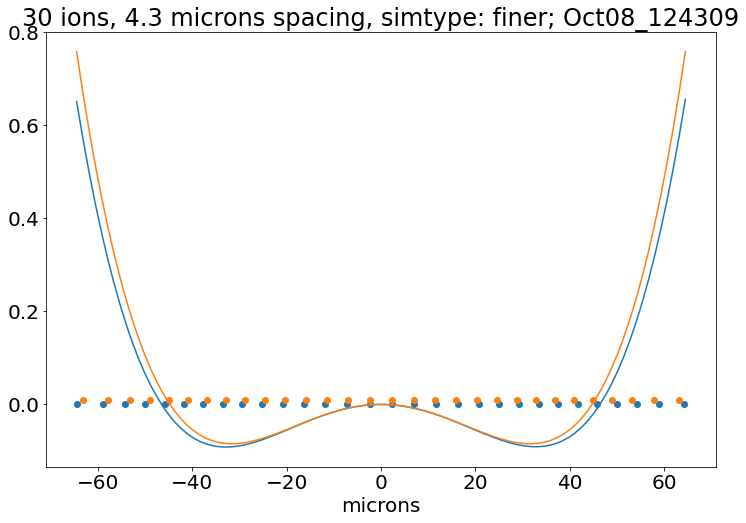

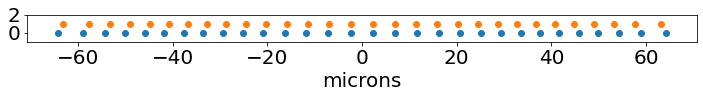

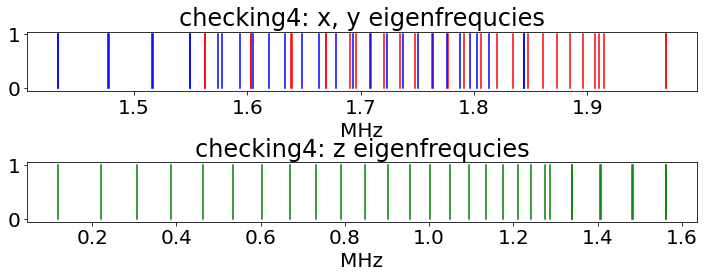

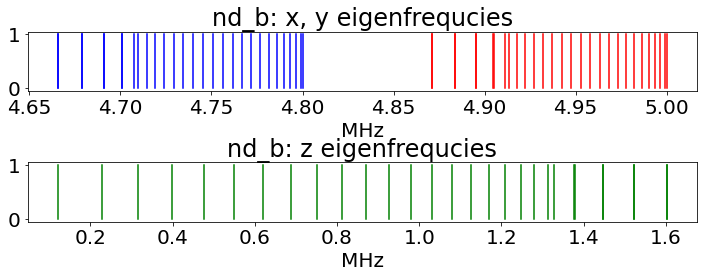

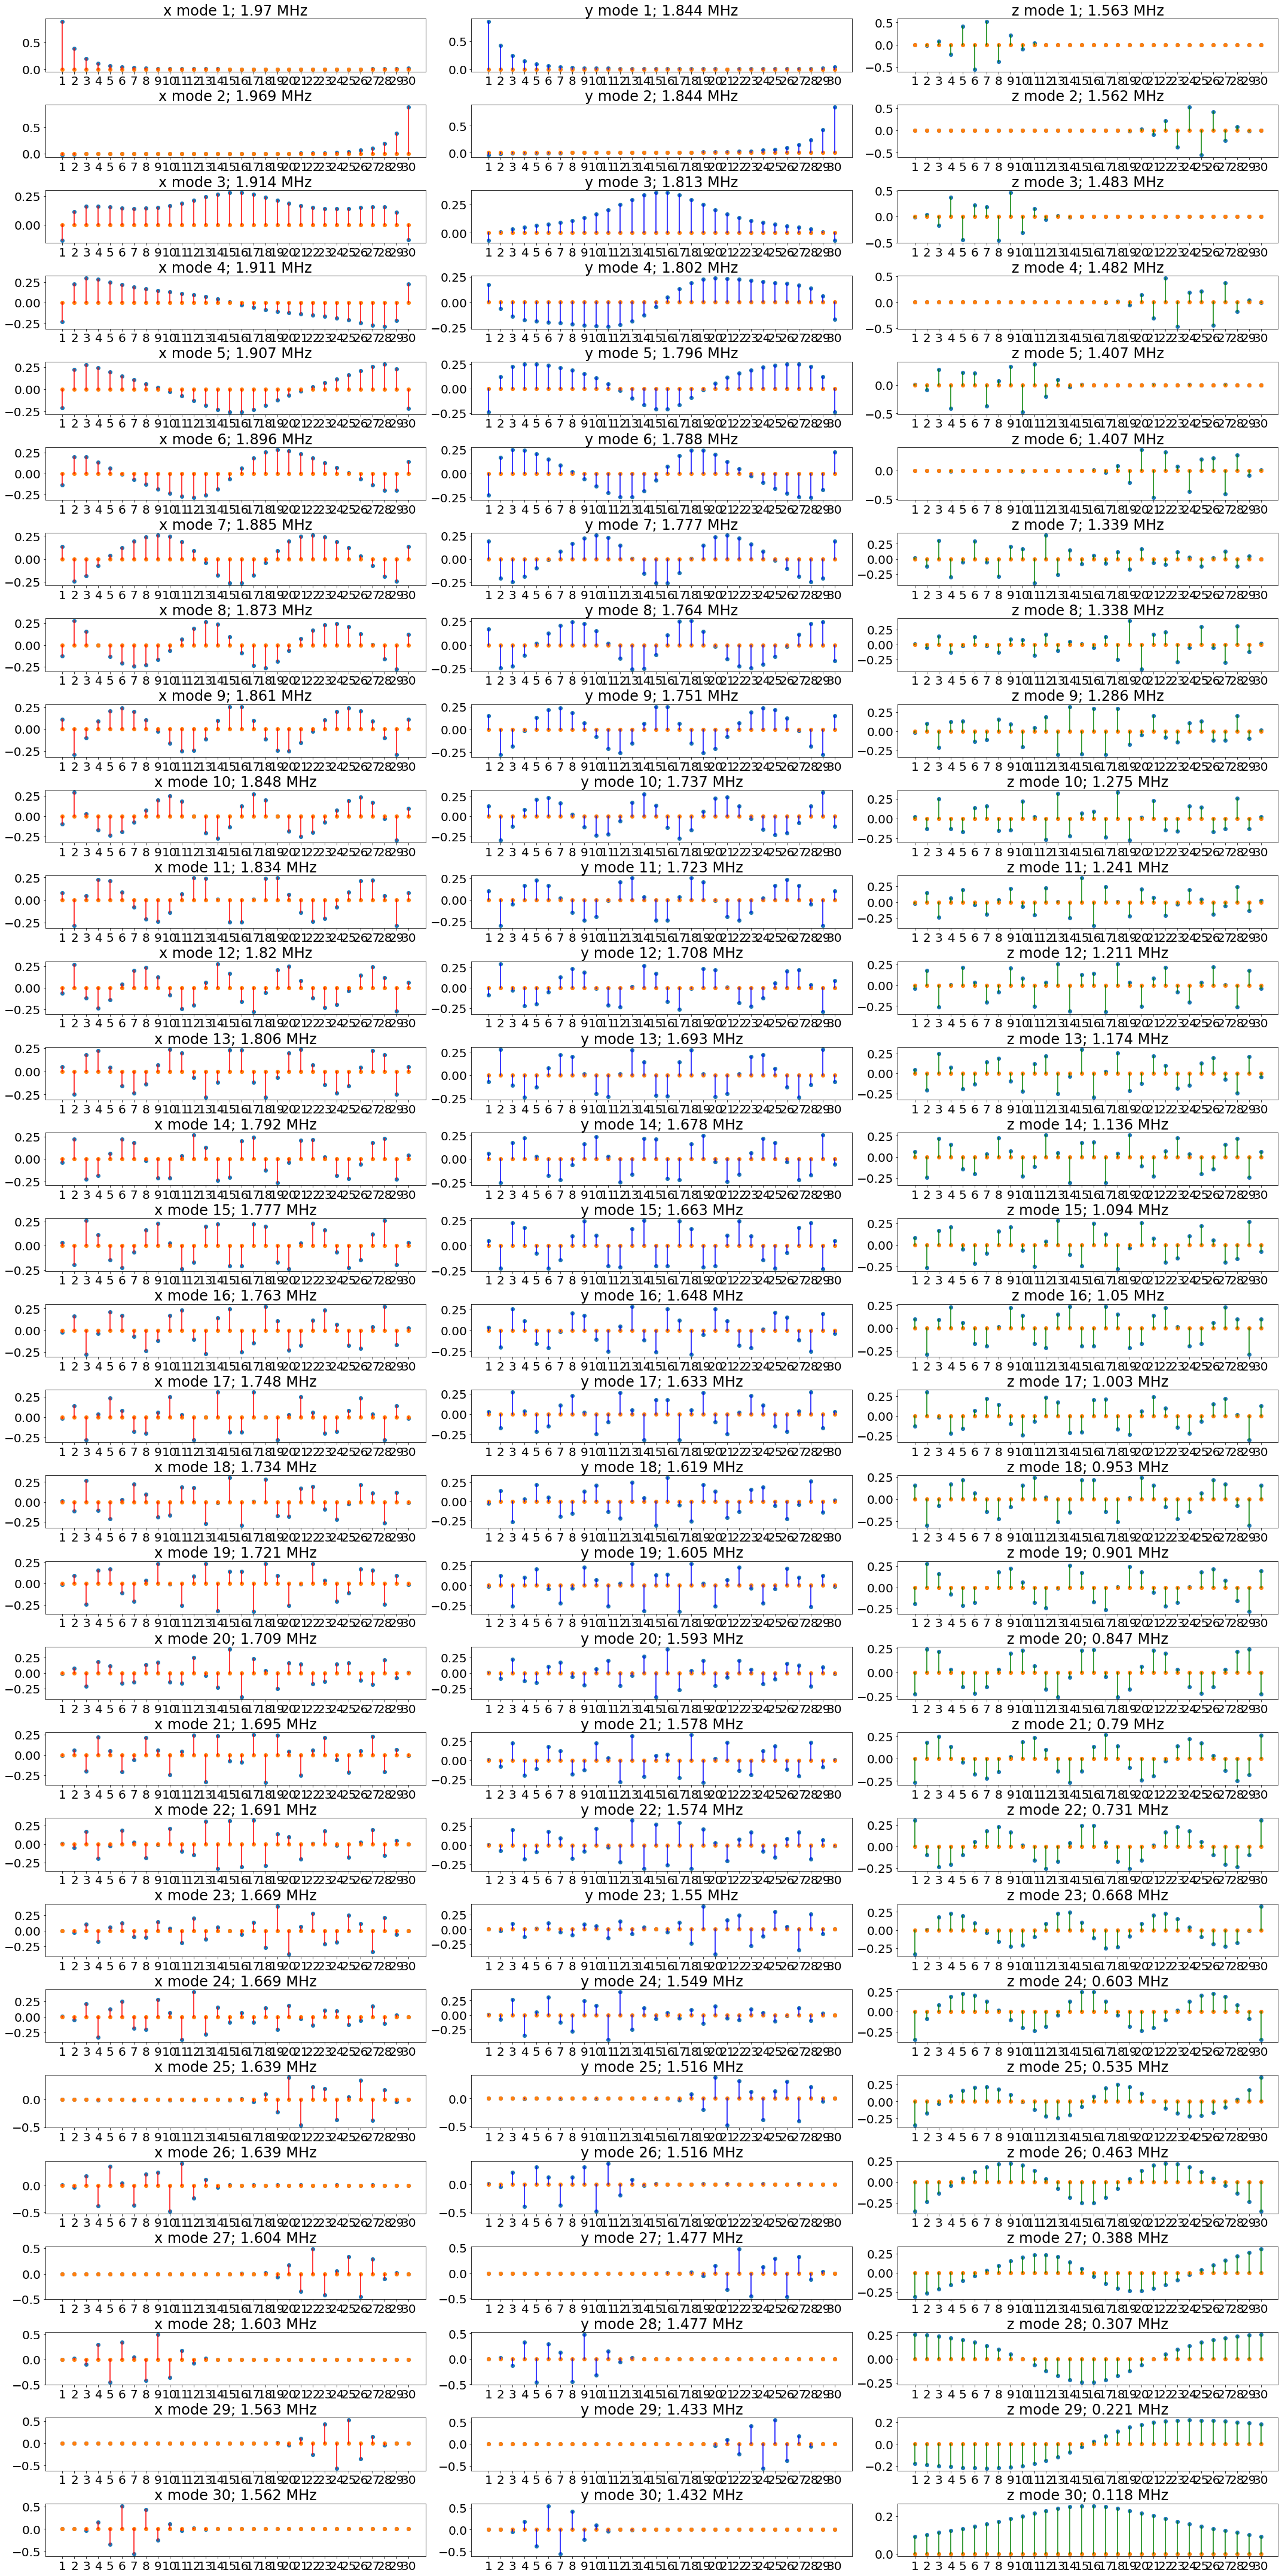

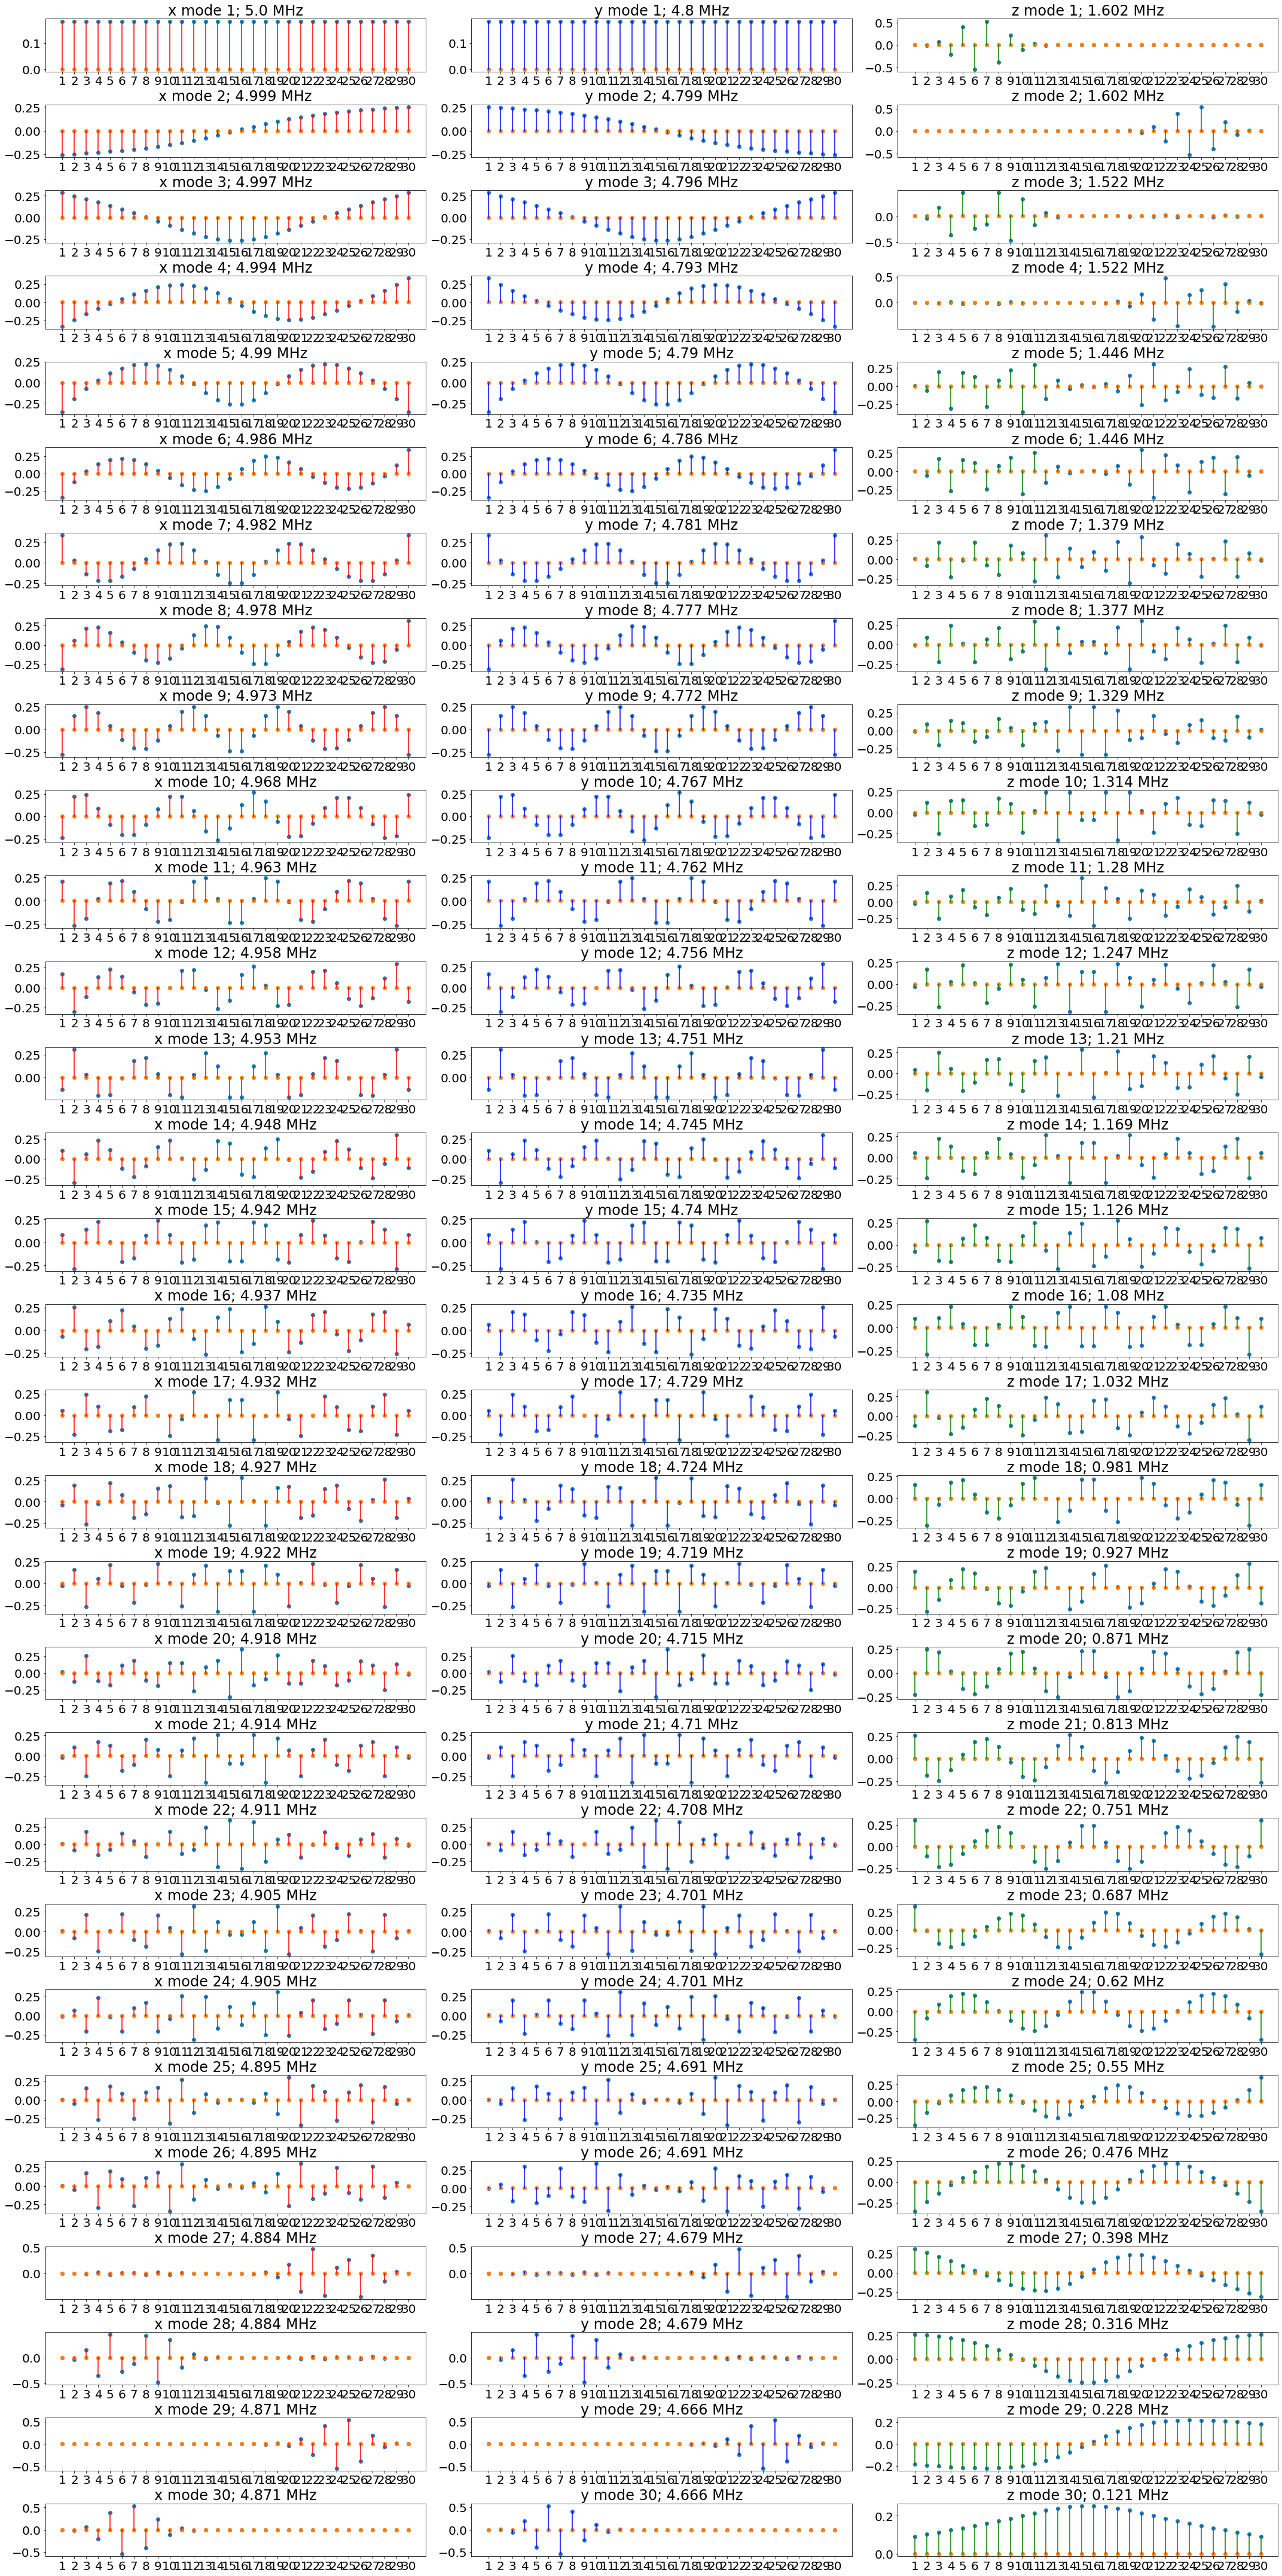

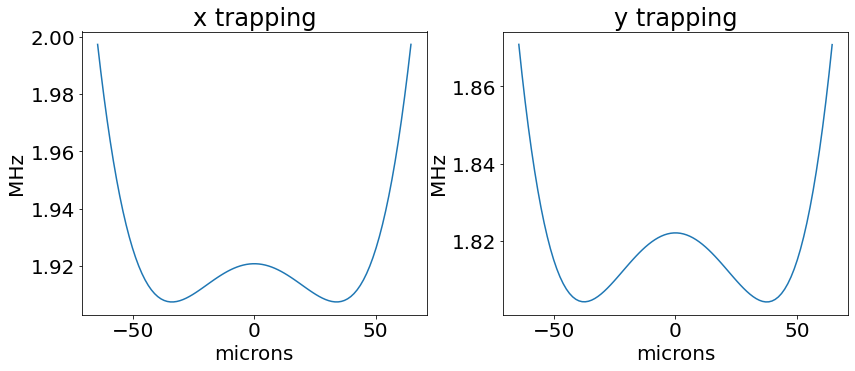

In [17]:
# np.set_printoptions(formatter={'float': lambda x: "{0:0.12f}".format(x)})

### single optim and char
# quartic20ions = VoltageOptim(simtype=SIMTYPE,ion_number=20) 

# print(f"non dim b = {np.reshape(quartic20ions.nd_b,(3,3,5))}")
# print(f"checking1: Av = {np.reshape(quartic20ions.checking,(3,3,5))}")
# # print(f"checking2: Av = {np.reshape(checking2,(3,3,5))}")
# # print(f"checking3: Av = {np.reshape(checking3, (3, 3, 5))}")
# print(f"checking4: Av = {np.reshape(quartic20ions.checking4, (3, 3, 5))}")

# print()
# print(f"full lsq_linear = {quartic20ions.v3_full}")
# print()
# print(f"full constrained lsq_linear = {quartic20ions.v4_full}")

# quartic20ions.characterization()

def optim_and_char(ion_num):
  optim_run = OptimChar(simtype=SIMTYPE,ion_number=ion_num,
                        init_type = 'quartic', optim_type = 'coeff')  
  # quadratic, quartic
  # coeff, grid

  print(f"non dim b = {np.reshape(optim_run.nd_b,(3,3,5))}")
  print(f"checking1: Av = {np.reshape(optim_run.checking,(3,3,5))}")
  # print(f"checking2: Av = {np.reshape(checking2,(3,3,5))}")
  # print(f"checking3: Av = {np.reshape(checking3, (3, 3, 5))}")
  print(f"checking4: Av = {np.reshape(optim_run.checking4, (3, 3, 5))}")

  print()
  print(f"full lsq_linear = {optim_run.v3_full}")
  print()
  print(f"full constrained lsq_linear = {optim_run.v4_full}")

  optim_run.characterization()
  return optim_run

test_ions = optim_and_char(30) # 30

# run multiple trials at the same time
# N_list = [20,22,24,26,28,30]
# optim_runs = []
# for ion_num in N_list:
#   print(f"ion number = {ion_num}")
#   optim_runs.append(optim_and_char(ion_num))



### test trical
# plot_trical(quartic20ions.checking4,j=1,num_ions=ion_number)
# plot_trical(quartic20ions.nd_b,j=2,num_ions=ion_number)
# current_time2 = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Eastern')).strftime("%b%d_%H%M%S")
# plt.title(str(ion_number)+' ions, '+str(MeanSpacing)+' microns spacing, simtype: '+SIMTYPE+\
#           '; '+current_time2)
# plt.show()
# checking4 nd_b



# time.sleep(5) # it takes time for the nbk to do the plot
# # if runtime is terminated too early, the plot is not shown
drive.flush_and_unmount()
# !kill -9 -1



# sys.exit()


## Results

In [18]:
# alpha_z, ti = optimize_quartic_z(57, mean_spacing=3, l=l)
# ti.w_pa[-1] / (2 * np.pi * 1e6)

In [19]:
# np.set_printoptions(formatter={'float': lambda x: "{0:0.12f}".format(x)})
# alpha_z, ti = optimize_quartic_z(20, mean_spacing=4, l=l)
# ti.w_pa[-1] / (2 * np.pi * 1e6)

In [20]:
# alpha_z, ti = optimize_quartic_z(57, mean_spacing=3, l=l)
# ti.w_pa[-1] / (2 * np.pi * 1e6)

In [21]:
# check order of magnitude of matrix
# print()
# print(rect_nbk.size)
# # print(rect_nbk[rect_nbk != 0].size)
# log_coeff = np.log10(np.abs(rect_nbk[rect_nbk != 0].flatten()))
# # log_coeff = np.log10(np.abs(rect_nbk[rect_nbk > 1e-20].flatten()))
# print(log_coeff.size)
# # log_coeff = np.log10(np.abs(rect_nbk.flatten())+1e-50)
# # print(rect_nbk.flatten())
# print(log_coeff)
# # sys.exit()
# plt.hist(log_coeff)
# plt.show()